Инициализация расчетной сетки

In [1]:
import numpy as np
import opticaldevicelib_2d as od_2d
import matplotlib.pyplot as plt
import cupy as cp
M = 32
# od_2d.OpticalDevice.init_values(new_dx=2e-8*M, new_dy=2e-8/M, new_Nx=2**12/M, new_Ny=2**12*M, gpu_use=True)
# od_2d.OpticalDevice.init_values(new_dx=2e-7, new_dy=1e-8, new_Nx=2**8, new_Ny=2**13, gpu_use=True)
# od_2d.OpticalDevice.init_values(new_dx=14e-8, new_dy=14e-8, new_Nx=2**8, new_Ny=2**8, gpu_use=True)
od_2d.OpticalDevice.init_values(new_dx=1e-7, new_dy=5e-8, new_Nx=2**9, new_Ny=2**10, gpu_use=True)
# od_2d.OpticalDevice.init_values(new_dx=0.325e-6, new_dy=0.325e-6, new_Nx=2**8, new_Ny=2**8, gpu_use=True)
print(f"границы поля X +- {od_2d.OpticalDevice.Nx * od_2d.OpticalDevice.dx * 1e6 / 2} мкм")
print(f"границы поля Y +- {od_2d.OpticalDevice.Ny * od_2d.OpticalDevice.dy * 1e6 / 2} мкм")

GPU is available!
GPU is available!
границы поля X +- 25.599999999999998 мкм
границы поля Y +- 25.599999999999998 мкм


Инициализация элементов для оптической схемы

In [2]:
p = od_2d.PointSource(z=15, En=12, x0=0, y0=0) 

try:
    x, y = p.x[0].get()*1e6, p.y[:,0].get()*1e6
except:
    x, y = p.x*1e6, p.y*1e6

E_ps1 = p.E() # плоская волна

N_gl = 26
Copy_flag = True
arr_len = 2 if Copy_flag else 2 * N_gl

phases = 2*np.pi*np.random.rand(arr_len)
w_s = (np.random.rand(arr_len)-0.5)*np.pi/180*0
s_s  = (np.random.rand(arr_len)-0.5)*2e-6*0

crl2D = od_2d.CRL2D(lam=p.lam, arr_start=E_ps1, z=0,\
                 R=6.25e-6, A=50e-6, d=2e-6, N_lens=N_gl, mol="Si", dens=2.33)


crl1D = od_2d.CRL1D(lam=p.lam, arr_start=E_ps1, z=0, \
                 R=6.25e-6, A=50e-6, d=2e-6, N_lens=N_gl, mol="Si", dens=2.33, \
                    lt=33e-6)

crl2Dm = od_2d.CRL2Dm(lam=p.lam, arr_start=E_ps1, z=0, \
                   R=6.25e-6, A=50e-6, d=2e-6, N_lens=N_gl, mol="Si", dens=2.33, \
                   copy=Copy_flag, arr_phase=phases, arr_s=s_s, arr_w=w_s, \
                    b=3e-8, m=2.5)

crl1Dm = od_2d.CRL1Dm(lam=p.lam, arr_start=E_ps1, z=0, \
                   R=6.25e-6, A=50e-6, d=2e-6, N_lens=N_gl, mol="Si", dens=2.33, \
                   copy=Copy_flag, \
                    lt=33e-6, dist_l=0e-6, dist_r=-0.35e-6, sigma=1.2e-6, height=0.1e-6, sigma_c=3e-6, height_c=-0.35e-6, shift=3.2e-6)

# crl1Dm = od_2d.CRL1Dm(lam=p.lam, arr_start=E_ps1, z=0, \
#                    R=6.25e-6, A=50e-6, d=2e-6, N_lens=N_gl, mol="Si", dens=2.33, \
#                    copy=Copy_flag, \
#                     lt=33e-6, dist_l=0e-6, dist_r=-0.3e-6, sigma=4, height=0.3e-6, sigma_c=2, height_c=-0.3e-6, shift=3.2e-6)



crl1Deq = od_2d.CRL1Deq(lam=p.lam, arr_start=E_ps1, z=0, \
                    R=6.25e-6, A=50e-6, d=2e-6, N_lens=N_gl, mol="Si", dens=2.33, \
                    copy=Copy_flag, lt=35e-6, dist_l=0e-7, dist_r=-0.3e-6, is_dist_const=False)


crl1Dcurv = od_2d.CRL1Dcurv(lam=p.lam, arr_start=E_ps1, z=0, \
                    R=6.25e-6, A=50e-6, d=2e-6, N_lens=N_gl, mol="Si", dens=2.33, \
                    copy=Copy_flag, lt=35e-6, ex_l='min', ex_r='max')


crl_global = crl1Dm # !!! SELECT TYPE OF CRL !!!
focus = crl_global.focus()
crl_global.set_z(z=focus)
print(f"фокусное расстояние = {focus * 1e3 :.3f} мм")
print(f"оценка макс. числа линз = {int(crl_global.Lc() * np.pi / 2)}")

фокусное расстояние = 34.634 мм
оценка макс. числа линз = 149


Отклонение профиля линзы

In [3]:
import opticaldevicelib_2d as od_2d
fft2d = od_2d.OpticalDevice.ft2d
ifft2d = od_2d.OpticalDevice.ift2d

def convolution_2d(signal, kernel, v, dx, dy):

    if v != 0:
        signal_padded = np.pad(signal, ((v, v), (v, v)), 'edge')
        kernel_padded = np.pad(kernel, ((v, v), (v, v)), 'edge')
    else:
        signal_padded = signal
        kernel_padded = kernel
    G = fft2d(signal_padded, dx, dy)
    H = fft2d(kernel_padded, dx, dy)

    convolved = ifft2d(G * H, dx, dy)
    if v != 0:
        convolved = convolved[v:-v, v:-v]
    return convolved.real

def gauss_2d(x, y, sig_x, sig_y):
    # X, Y = np.meshgrid(x, y)
    norm = 1 / (2 * np.pi * sig_x * sig_y)
    return  norm * np.exp(-(X/sig_x)**2/2 - (Y/sig_y)**2/2)

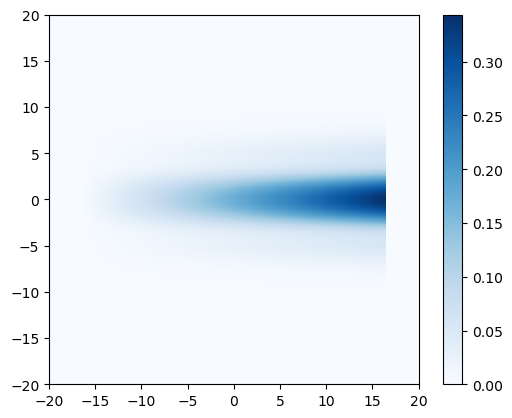

In [4]:
def plot_pcolor_save(x, y, data):

    from matplotlib.widgets import Slider
    # plt.clf()
    %matplotlib inline

    # Создаем фигуру и оси
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    # Начальное отображение
    c = ax.pcolormesh(x, y, data, shading='auto', cmap="Blues")
    plt.colorbar(c)
    # plt.axis("off")
    plt.ylim(-20, 20)
    plt.xlim(-20, 20)
    # plt.xlim(-35/2, 35/2)
    plt.savefig(f"dt", bbox_inches='tight', pad_inches=0, dpi=400)

T_global = crl_global.T().get()*1e6
T_ideal = crl1D.T().get()*1e6

# X, Y = np.meshgrid(x, y)

# S = 0.3 * (X + 35/2) / 35

# S[abs(X)>17.5] = np.nan
# S[abs(Y)>20] = np.nan

# def y_cross(R2, l, R):
#     return l + R2 - R - np.sqrt((R2-R)**2-2*R*l)

# def circle(x, R2, l, R):
#     return -np.sqrt(R2**2-x**2) + l + R

# y_cros_val = y_cross(R2=10, l=S, R=6.25)

# circ = circle(x=Y, R2=10, l=S, R=6.25)

# # circ[abs(X)>17.5] = 0
# # circ[circ>y_cros_val] = 0

# T_global = T_ideal.copy()
# T_global[T_global<y_cros_val] = circ[T_global<y_cros_val]

# # circ[abs(Y)>y_cros_val] = 0

# plt.pcolormesh(X, Y, circ)

plot_pcolor_save(x, y, T_global-T_ideal)

Профиль линзы в сечении

nearest elem is 12.950000762939453


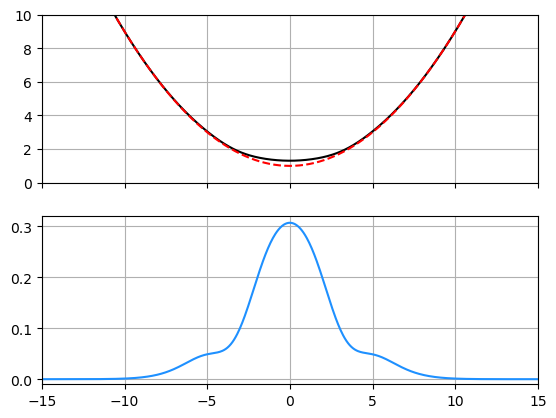

In [ ]:
def nearest_elem_index(elem, data):
    idx = np.where(data == data.flat[np.abs(data -  elem).argmin()])[0][0]
    print(f"nearest elem is {data[idx]}")
    return int(idx)

def compute_curvature_radius(y):
    # Вычисляем первую производную
    dy = np.gradient(y)
    # Вычисляем вторую производную
    d2y = np.gradient(dy)

    # Вычисляем радиус кривизны
    R = (1 + dy**2)**(3/2) / np.abs(d2y)
    
    return 1 / R


def plot_profile_slice(x0, x, y, T_global, T_ideal):

    %matplotlib inline

    idx = nearest_elem_index(x0, x)
    T_global = T_global.T[idx]
    T_ideal = T_ideal.T[idx]

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    ax1.set_xlim(-15, 15)
    ax1.set_ylim(0, 10)
    ax1.grid()
    ax1.plot(y, T_global, 'k', label='1')
    ax1.plot(y, T_ideal, "r--", label='2')
    ax2.plot(y, T_global-T_ideal, "dodgerblue", label='3')
    # ax2.set_xlim(-15, 15)
    ax2.set_ylim(-0.01, 0.32)
    # plt.savefig("topology.png", pad_inches=0, dpi=400)
    # plt.axvline(3.2)
    # plt.axvline(-3.2)
    ax2.grid()
    plt.show()

plot_profile_slice(13, x, y, T_global, T_ideal)

nearest elem is 12.950000762939453
nearest elem is 12.950000762939453


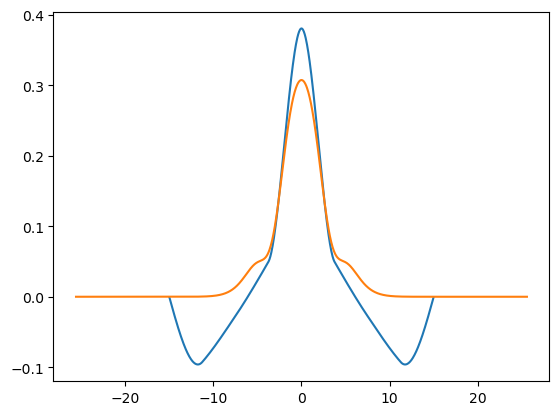

In [23]:
from scipy.interpolate import Akima1DInterpolator, CubicSpline, PchipInterpolator

def coefs_to_spline(x, x_edge, n_peaks, coefs):
    x_peaks = np.linspace(-x_edge, x_edge, n_peaks+2)
    xnew = x[abs(x)<x_edge]
    y_peaks = coefs
    y_peaks = np.concatenate([y_peaks[:0:-1], y_peaks])
    y_peaks = np.pad(y_peaks, pad_width=1, mode='constant', constant_values=0)
    spl = Akima1DInterpolator(x_peaks, y_peaks)
    # spl = CubicSpline(x_peaks, y_peaks)
    # spl = PchipInterpolator(x_peaks, y_peaks)
    return spl(xnew)

x_edge = 15

# coefs_experiment = np.array([-0.37580994, -0.60104007, -0.83018035, -0.91310686]) + 0.9
coefs_experiment = np.array([0.03037248, -0.30044696, -0.37744778, -0.4424736]) + 0.35

spline_test = coefs_to_spline(y, x_edge, 7, coefs_experiment)

plt.plot(y[abs(y)<x_edge], spline_test)


# idx = 

plt.plot(y, T_global.T[nearest_elem_index(13, x)] - T_ideal.T[nearest_elem_index(13, x)])

In [6]:
%matplotlib widget
from matplotlib.widgets import Slider

def plot_profile_slice_slider():
    Z2 = crl_global.T().get()*1e6
    Z2 = Z2.T

    Z3 = crl1D.T().get()*1e6
    Z3 = Z3.T

    # Создаем массив данных (можно использовать свои данные)
    # data = focus_images[np.max(np.where(z_arr-focus_2d<-1.5e-3))].T
    data = Z2
    # Создаем начальный график по индексу 0
    fig, ax = plt.subplots()
    l, = ax.plot(y, data[0])
    l2, = ax.plot(y, Z3[0])
    l3, = ax.plot(y, data[0] - Z3[0])
    ax.set_ylim(-1, 10)
    # ax.set_ylim(-1, 53)
    # ax.set_xlim(x[abs(x)<17.5], y[abs(y)<25])
    ax.set_xlim(-20, 20)
    # Создаем слайдер
    axcolor = 'lightgoldenrodyellow'
    slider_ax = plt.axes([0.2, 0.02, 0.65, 0.03], facecolor=axcolor)
    slider = Slider(slider_ax, 'Index', 0, len(data)-1, valinit=0, valstep=1)


    # Функция обновления графика по индексу
    def update(val):
        index = int(slider.val)
        l.set_ydata(data[index])
        l2.set_ydata(Z3[index])
        l3.set_ydata((data[index] - Z3[index])*10)
        # l.set_xdata(y_cutted)
        # ax.set_title("$x$ = "+ f"{(x_cutted[index]):.1f} μм")
    
        plt.draw()

    slider.on_changed(update)
    plt.grid()
    plt.show()

In [7]:
"""Точечный источник"""
z_arr = np.arange(0, 55, 2) * 1e-3
# z_arr = np.array([focus])
I_distr_max, I_max, dz_max, dy_max, dx_max, fwhm_y, fwhm_x, focus_images, z_arr_, div_ang_x, div_ang_y, x_cutted, y_cutted\
     = crl_global.focus_params(z_arr, T_arr=cp.array(T_global)*1e-6, ny_cut=int(20e-6/od_2d.OpticalDevice.dy), nx_cut=int(20e-6/od_2d.OpticalDevice.dx), focus=34e-3)
print(f" dz = {dz_max} mm \n dx = {dx_max} μm \n dy = {dy_max} μm \n fwhm_x = {fwhm_x*1e6} μm \n fwhm_y = {fwhm_y*1e6} μm \n I_max = {I_max} rel. un. \n div_ang_x = {div_ang_x} \n div_ang_y = {div_ang_y}")
I_sum_dot = abs(focus_images)**2
phase_dot = np.unwrap(np.angle(focus_images), period=np.pi)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 982.22it/s]


 dz = 0.0 mm 
 dx = -14.85 μm 
 dy = 0.024999999999999998 μm 
 fwhm_x = nan μm 
 fwhm_y = 0.3053015587054101 μm 
 I_max = 50.09184581261458 rel. un. 
 div_ang_x = 3.3066666422776336e-06 
 div_ang_y = 0.00029597751570897834


[]

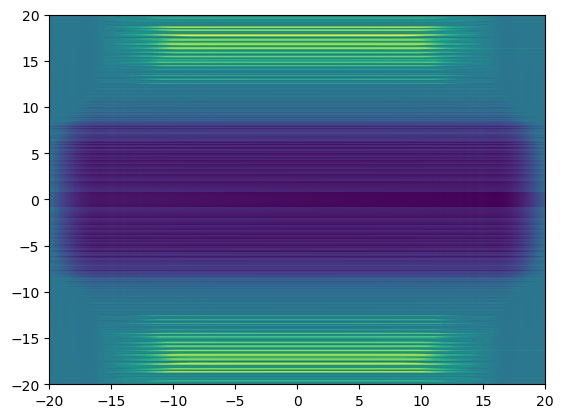

In [8]:
%matplotlib inline
# plt.pcolormesh(x_cutted, y_cutted, I_sum_dot[9].get())

plt.pcolormesh(x_cutted, y_cutted, phase_dot[9].get())
plt.plot()

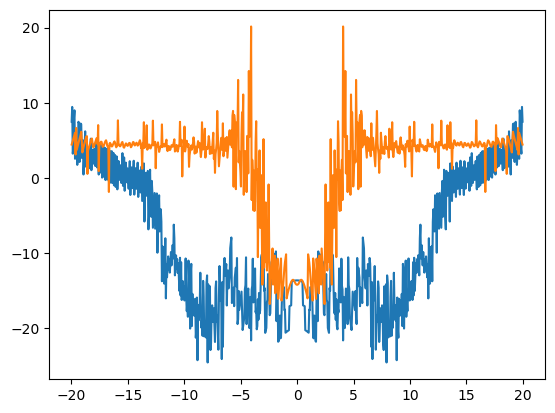

In [9]:
plt.plot(y_cutted, phase_dot[5, :, 350].get())
plt.plot(y_cutted, phase_dot[15, :, 350].get())

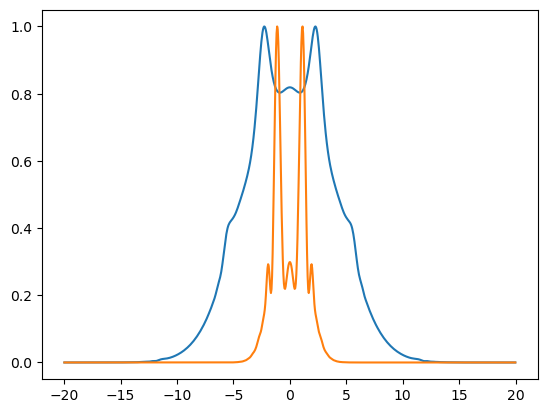

In [10]:
plt.plot(y_cutted, I_sum_dot[5, :, 350].get() / np.max(I_sum_dot[5, :, 350].get()))
plt.plot(y_cutted, I_sum_dot[13, :, 350].get() / np.max(I_sum_dot[13, :, 350].get()))

In [14]:
crl_global.set_z(z=focus)
I_arr_test = crl_global.I()
z_arr = np.arange(14, 55, 2) * 1e-3

N_source_x, N_source_y = 21, 21

size_source_x = cp.linspace(-2e-3, 2e-3, N_source_x)
size_source_y = cp.linspace(-2e-4, 2e-4, N_source_y)


def gauss_2d(x, y, sig_x, sig_y):
    return np.exp(-0.5 * ((x/sig_x)**2 + (y/sig_y)**2))

gauss_test = cp.zeros(shape=(N_source_x, N_source_y))

sig_x = 1.03e-3/2.355
sig_y = 1.17e-4/2.355

# sh1, sh2 = I_arr_test.shape
sh_z = len(z_arr)
I_sum = cp.zeros(shape=(sh_z, int(20e-6/od_2d.OpticalDevice.dy)*2, int(20e-6/od_2d.OpticalDevice.dx)*2))
I_sum_ideal = cp.zeros(shape=(sh_z, int(20e-6/od_2d.OpticalDevice.dy)*2, int(20e-6/od_2d.OpticalDevice.dx)*2))

# phase_sum = cp.zeros(shape=(sh_z, int(20e-6/od_2d.OpticalDevice.dy)*2, int(20e-6/od_2d.OpticalDevice.dx)*2))
# phase_sum_ideal = cp.zeros(shape=(sh_z, int(20e-6/od_2d.OpticalDevice.dy)*2, int(20e-6/od_2d.OpticalDevice.dx)*2))

# t_loop = crl_global.T()
t_loop = cp.array(T_global) * 1e-6

for i, x0 in enumerate(size_source_x):
    for j, y0 in enumerate(size_source_y):
        p_loop = od_2d.PointSource(En=12, z=15, x0=x0, y0=y0)
        E_p_loop = p_loop.E()

        crl_loop = od_2d.CRL1Dm(lam=p_loop.lam, arr_start=E_p_loop, z=0, \
                   R=6.25e-6, A=50e-6, d=2e-6, N_lens=N_gl, mol="Si", dens=2.33, copy=Copy_flag, \
                    lt=35e-6, dist_l=0e-6, dist_r=-0.35e-6, sigma=0.7e-6, height=0.0e-6, sigma_c=3e-6, height_c=-0.2e-6, shift=3.2e-6)

        crl_loop_ideal = od_2d.CRL1D(lam=p.lam, arr_start=E_p_loop, z=0, \
            R=6.25e-6, A=50e-6, d=2e-6, N_lens=N_gl, mol="Si", dens=2.33, \
                lt=35e-6)

        gauss_test[i][j] = gauss_2d(x0, y0, sig_x, sig_y)
        
        I_distr_max, I_max, dz_max, dy_max, dx_max, fwhm_y, fwhm_x, focus_images, z_arr_, div_ang_x, div_ang_y, x_cutted, y_cutted\
                    = crl_loop.focus_params(z_arr=z_arr+2e-3, T_arr=t_loop, ny_cut=int(20e-6/od_2d.OpticalDevice.dy), nx_cut=int(20e-6/od_2d.OpticalDevice.dx))
        I_sum += abs(focus_images)**2 * gauss_test[i][j] / N_source_x / N_source_y
        # phase_sum = np.unwrap(np.angle(focus_images), period=np.pi)

        I_distr_max, I_max, dz_max, dy_max, dx_max, fwhm_y, fwhm_x, focus_images, z_arr_, div_ang_x, div_ang_y, x_cutted, y_cutted\
            = crl_loop_ideal.focus_params(z_arr=z_arr+2e-3, ny_cut=int(20e-6/od_2d.OpticalDevice.dy), nx_cut=int(20e-6/od_2d.OpticalDevice.dx))
        I_sum_ideal += abs(focus_images)**2 * gauss_test[i][j] / N_source_x / N_source_y
        # phase_sum_ideal = np.unwrap(np.angle(focus_images))

100%|██████████| 25/25 [00:00<00:00, 556.01it/s]


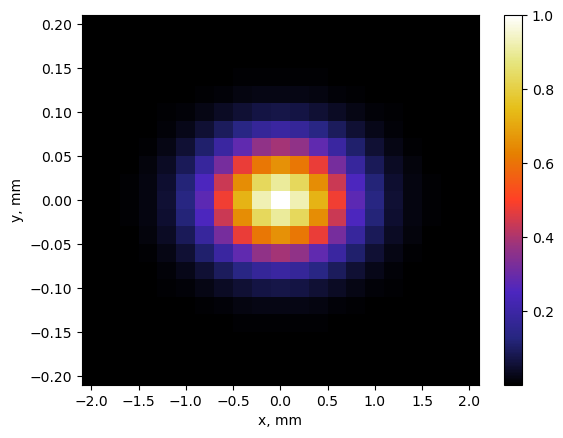

In [15]:
%matplotlib inline
fig, ax = plt.subplots()
# ax.set_aspect('equal')
ccc = plt.pcolormesh(size_source_x.get()*1e3, size_source_y.get()*1e3, gauss_test.get(), cmap="CMRmap")
plt.colorbar(ccc)
    # plt.grid()
# plt.xlim(-20, 20)
# plt.ylim(-20, 20)
plt.xlabel("x, mm")
plt.ylabel("y, mm")
plt.show()

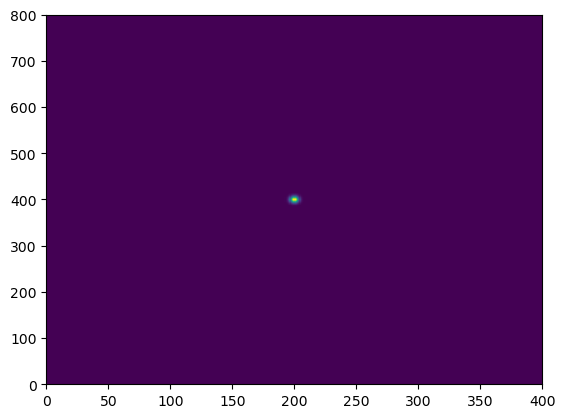

In [16]:
%matplotlib inline
import opticaldevicelib_2d as od_2d
fft2d = od_2d.OpticalDevice.ft2d
ifft2d = od_2d.OpticalDevice.ift2d

def convolution_2d(signal, kernel, v, dx, dy):

    if v != 0:
        signal_padded = np.pad(signal, ((v, v), (v, v)), 'edge')
        kernel_padded = np.pad(kernel, ((v, v), (v, v)), 'edge')
    else:
        signal_padded = signal
        kernel_padded = kernel
    G = fft2d(signal_padded, dx, dy)
    H = fft2d(kernel_padded, dx, dy)

    convolved = ifft2d(G * H, dx, dy)
    if v != 0:
        convolved = convolved[v:-v, v:-v]
    return convolved.real

def gauss_2d(x, y, sig_x, sig_y):
    X, Y = np.meshgrid(x, y)
    norm = 1 / (2 * np.pi * sig_x * sig_y)
    return  norm * np.exp(-(X/sig_x)**2/2 - (Y/sig_y)**2/2)


dx_cut = x_cutted[1] - x_cutted[0]
dy_cut = y_cutted[1] - y_cutted[0]

gauss_core = gauss_2d(x_cutted, y_cutted, 0.24, 0.24)
plt.pcolormesh(gauss_core)


filter_arr = I_sum.get().copy()
I_filtered = np.zeros(shape=filter_arr.shape)
# I_filtered = np.zeros(shape=(200, 100))
I_filtered_exp = np.zeros(shape=filter_arr.shape)
import opticaldevicelib_2d as od_2d
for i, I_slide in enumerate(filter_arr):
    I_filtered[i] = convolution_2d(signal=I_slide, kernel=gauss_core, v=200, dx=dx_cut, dy=dy_cut)

In [17]:
volume = I_filtered
# volume = phase_sum.get()
# volume = I_sum_dot.get()
# volume_exp = I_filtered_exp
# volume = I_sum.get()

volume_ideal = I_sum_ideal.get()
# volume_ideal = phase_sum_ideal.get()

def read_res(folder, model_name):
    x = np.load(f"{folder}/{model_name}/x.npy")
    y = np.load(f"{folder}/{model_name}/y.npy")
    data_interp = np.load(f"{folder}/{model_name}/data_interp.npy")
    data_deconv = np.load(f"{folder}/{model_name}/data_deconv.npy")
    
    return x, y, data_interp, data_deconv

x_ftian, y_ftian, data_interp, data_deconv = read_res("FTIAN_2/ftian_cache", "2d_res")

z_ftian = np.arange(14, 55, 2) * 1e-3

nearest elem is -12.950000762939453


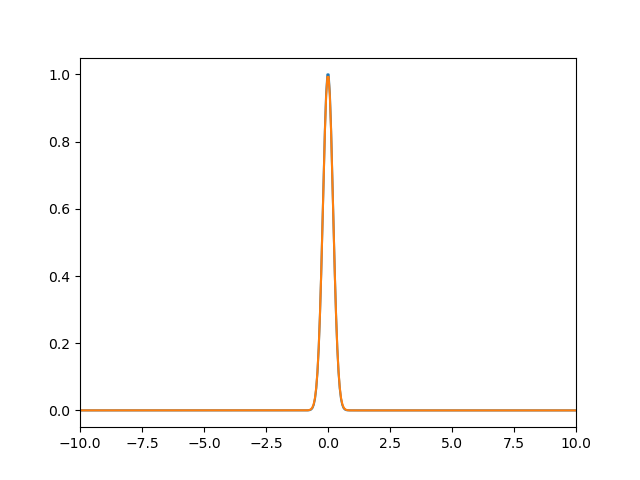

0.4819694810523786 -1.4377392848172445e-07


In [184]:
from scipy.optimize import curve_fit

def gauss_fit(x, a, b):
    return np.exp(-(x-b)**2/(2*a**2))

peak = volume_ideal.copy()[9, :, nearest_elem_index(-13, x_cutted)]
peak /= np.max(peak)
[a, b], res1 = curve_fit(lambda x_psf, a, b: gauss_fit(x_psf, a, b), y_cutted, peak)

plt.plot(y_cutted, peak, label='focus peak')
plt.plot(y_cutted, gauss_fit(y_cutted, a, b), label='gaussian fit')
plt.xlim(-10, 10)
plt.show()
print(a*2.355, b)

In [18]:
def plot_pcolor_slider(x, y, z, data):

    from matplotlib.widgets import Slider
    # plt.clf()
    %matplotlib tk

    # Создаем фигуру и оси
    fig, ax = plt.subplots()
    plt.subplots_adjust(bottom=0.2)
    ax.set_aspect('equal')
    # Начальное отображение
    c = ax.pcolormesh(x, y, data[0]/np.max(data[0]), rasterized=True, cmap='CMRmap')
    # ax.grid()
    plt.title(f'z = {z_arr[0]}')
    plt.colorbar(c)
    plt.xlim(-20, 20)
    plt.ylim(-20, 20)
    # Настраиваем слайдер
    ax_slider = plt.axes([0.3, 0.05, 0.45, 0.03])  # (left, bottom, width, height)
    slider = Slider(ax_slider, 'Index', 0, len(data)-1, valinit=0, valstep=1)

    # Функция обновления графика при изменении слайдера
    def update(val):
        idx = int(slider.val)
        c.set_array(data[idx].flatten())
        # c.set_array(data[idx].flatten()/np.max(data[idx].flatten()))
        ax.set_title(f'z = {z[idx]}')
        fig.canvas.draw()

    slider.on_changed(update)

# plot_pcolor_slider(x_interp_shift, y_interp_shift, z_arr, data_deconv.get()/np.max(data_deconv.get()))
plot_pcolor_slider(x_cutted, y_cutted, z_arr*1e3+2, volume)

z = 44.0


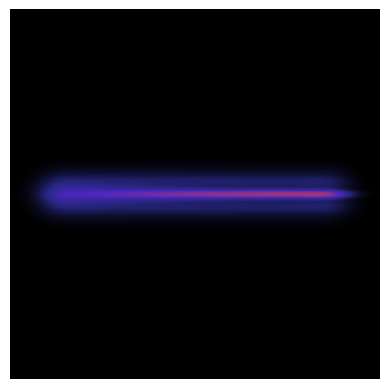

In [19]:
def plot_pcolor_save(x, y, data):

    %matplotlib inline

    # plt.clf()
    # %matplotlib widget

    # Создаем фигуру и оси
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    # Начальное отображение
    c = ax.pcolormesh(x, y, data, shading='auto', cmap='CMRmap', vmin=0, vmax=1)
    # plt.colorbar(c)
    # plt.grid()
    plt.xlim(-20, 20)
    plt.ylim(-20, 20)
    plt.axis("off")
    plt.savefig(f"FTIAN_2/model_pics/44_model_detector.png", bbox_inches='tight', pad_inches=0, dpi=400)
    fig.canvas.draw()

idx = 9 + 5
print(f"z = {z_arr[idx]*1e3+2}")
plot_pcolor_save(x_cutted, y_cutted, volume[idx]/np.max(volume))

nearest elem is 12.950000762939453
3.8240192373137276 1.5874506971990597e-05


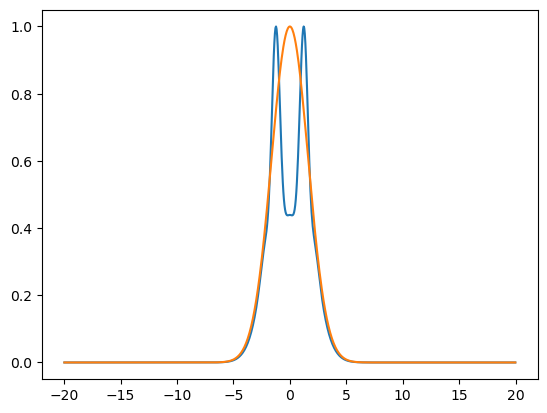

In [20]:
peak = volume.copy()[4, :, nearest_elem_index(13, x_cutted)]
peak /= np.max(peak)
# plt.plot(peak)

from scipy.optimize import curve_fit

def gauss_fit(x, a, b):
    return np.exp(-(x-b)**2 / (2 * a**2))

[a, b], res1 = curve_fit(lambda x_psf, a, b: gauss_fit(x_psf, a, b), y_cutted, peak)

%matplotlib inline
plt.plot(y_cutted, peak, label='focus peak')
plt.plot(y_cutted, gauss_fit(y_cutted, a, b), label='gaussian fit')
# plt.xlim(-10, 10)
print(a*2.355, b)

FWHM(z)

In [21]:
%matplotlib inline

from scipy.interpolate import interp1d

def calculate_fwhm(data, dy):

    x_arr = np.arange(len(data))
    f = interp1d(x_arr, data)
    k = 5
    x_new = np.linspace(x_arr[0], x_arr[-1], len(data)*k)
    data = f(x_new)

    # Находим максимальное значение
    max_val = np.max(data)
    
    # Вычисляем половину максимума
    half_max = max_val / 2.0
    
    # Находим индексы, где данные пересекают половину максимума
    indices = np.where(data >= half_max)[0]
    
    if len(indices) < 2:
        return 0  # FWHM не определен, если нет пересечений
    
    # Находим первый и последний индексы
    left_index = indices[0]
    right_index = indices[-1]
    
    # Вычисляем FWHM
    fwhm = right_index - left_index
    # plt.plot(data)
    # plt.plot(np.array([left_index, right_index]), np.array([data[left_index], data[right_index]]))
    # plt.show()
    
    return fwhm * dy / k, max_val

FWHM_arr_model = np.empty(shape=len(z_arr))
FWHM_arr_model_ideal = np.empty(shape=len(z_arr))
FWHM_arr_raw = np.empty(shape=len(z_ftian))
FWHM_arr_deconv = np.empty(shape=len(z_ftian))

peak_arr_model = np.empty(shape=len(z_arr))
peak_arr_model_ideal = np.empty(shape=len(z_arr))
peak_arr_raw = np.empty(shape=len(z_ftian))
peak_arr_deconv = np.empty(shape=len(z_ftian))

x0 = 13


for i in range(len(z_arr)):

    FWHM_arr_model[i], peak_arr_model[i] = calculate_fwhm(volume.copy()[i, :, nearest_elem_index(x0, x_cutted)], (y_cutted[1] - y_cutted[0]))

    FWHM_arr_model_ideal[i], peak_arr_model_ideal[i] = calculate_fwhm(volume_ideal.copy()[i, :, nearest_elem_index(x0, x_cutted)], (y_cutted[1] - y_cutted[0]))

for i in range(len(z_ftian)):

    FWHM_arr_raw[i], peak_arr_raw[i] = calculate_fwhm(data_interp.copy()[i, :, nearest_elem_index(x0, x_ftian)], (y_ftian[1] - y_ftian[0]))

    FWHM_arr_deconv[i], peak_arr_deconv[i] = calculate_fwhm(data_deconv.copy()[i, :, nearest_elem_index(x0, x_ftian)], (y_ftian[1] - y_ftian[0]))

nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.950000762939453
nearest elem is 12.9

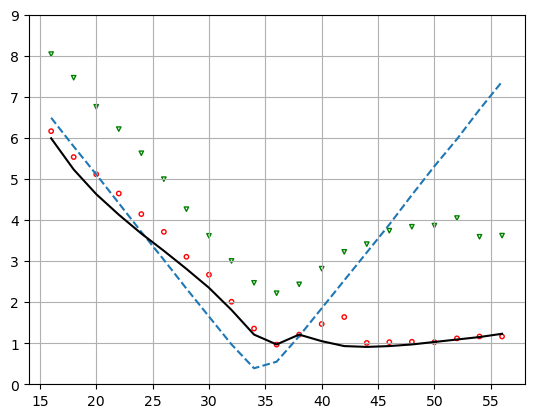

In [22]:
%matplotlib inline
plt.plot(z_arr*1e3+2, FWHM_arr_model_ideal, "--", label="модель без учета технол. отклонений")
plt.plot(z_arr*1e3+2, FWHM_arr_model, "black", label="модель с учетом технол. отклонений")
plt.scatter(z_ftian*1e3+2,  FWHM_arr_raw, marker="v", facecolors='none', edgecolors='green', s=10, label="экспериментальные данные")
plt.scatter(z_ftian*1e3+2, FWHM_arr_deconv, facecolors='none', edgecolors='r', s=10, label="экспериментальные данные после обработки")
# plt.scatter(z_arr*1e3, FWHM_arr_model, facecolors='none', edgecolors='b', s=10)
# plt.legend()
plt.grid()
plt.ylim(0, 9)
# plt.xlabel("$\\z, mm$")
# plt.ylabel("$FWHM, µm$")

plt.savefig(f"FTIAN_2/model_pics/FWHM_verh.png", bbox_inches='tight', pad_inches=0, dpi=400)
plt.show()

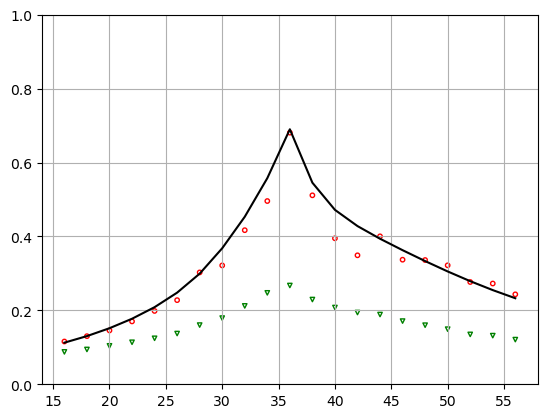

In [23]:
plt.plot(z_arr*1e3+2, peak_arr_model / np.max(volume), "black", label="модель с учетом технол. откл.")
plt.scatter(z_ftian*1e3+2, peak_arr_raw / np.max(data_deconv), marker="v", facecolors='none', edgecolors='green', s=10, label="экспериментальные данные")
plt.scatter(z_ftian*1e3+2, peak_arr_deconv / np.max(data_deconv), facecolors='none', edgecolors='r', s=10, label="экспер. данные после обработки")

# plt.scatter(z_arr*1e3, FWHM_arr_model, facecolors='none', edgecolors='b', s=10)

# plt.plot(z_arr*1e3+2, peak_arr_model_ideal / np.max(volume), label="model ideal CRL")
# plt.legend()
plt.ylim(0, 1)
# plt.xlim(15, 57)
plt.grid()
# plt.xlabel("$z, mm$")
# plt.ylabel("$max(I(x,y)), a. u.$")
plt.savefig(f"FTIAN_2/model_pics/peak_dno.png", bbox_inches='tight', pad_inches=0, dpi=400)
plt.show()

nearest elem is 13.004989986648866
nearest elem is 13.004989986648866
nearest elem is -0.011498664886516963
nearest elem is -0.011498664886516963
nearest elem is -13.004989986648868
nearest elem is -13.004989986648868


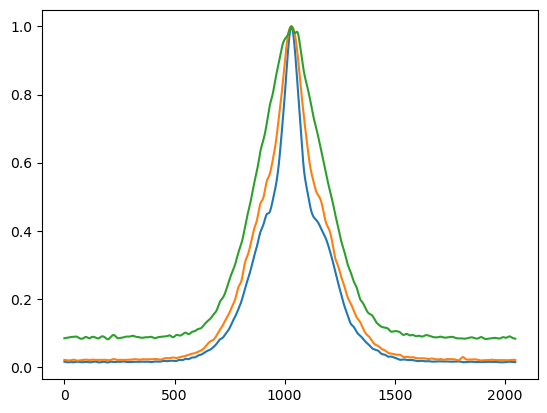

In [24]:
plt.plot(data_interp.copy()[i, :, nearest_elem_index(13, x_ftian)]/np.max(data_interp.copy()[i, :, nearest_elem_index(13, x_ftian)]))
plt.plot(data_interp.copy()[i, :, nearest_elem_index(0, x_ftian)]/np.max(data_interp.copy()[i, :, nearest_elem_index(0, x_ftian)]))
plt.plot(data_interp.copy()[i, :, nearest_elem_index(-13, x_ftian)]/np.max(data_interp.copy()[i, :, nearest_elem_index(-13, x_ftian)]))

In [20]:
def lorenz_2d(x, y, sig_x, sig_y):
    # A = sig_x / (2 * np.pi)
    # A = sig**3
    # core = 1 / (x**2 + sig_x**2)
    # A = 1 / np.max(core)
    # return A / (x**2 + y**2 + sig**2) ** (3/2)
    x, y = np.meshgrid(x, y)
    core = 1 / (2 * np.pi * sig_x * sig_y * (1 + (x/sig_x)**2 + (y/sig_y)**2)**(3/2))
    return core

def laplace_2d(x, y, a, b):
    X, Y = np.meshgrid(x, y)
    # alpha = np.sqrt(sig_x**2+sig_y**2)
    return np.exp(-a*np.sqrt((X)**2+(Y)**2)**b) 

In [27]:
lines_cache = []

def plot_slice_x_slider(x0, x, y, z, data):

    # предварительная подготовка plot
    from matplotlib.widgets import Slider 

    plt.close()
    %matplotlib tk

    # по x0 находим нужный слой в x
    N_slice = nearest_elem_index(x0, x)
    data = data[:, :, N_slice]
    # data = data / np.max(data)

    # кэширование всех инпутов
    global lines_cache
    lines_cache.append([x0, x, y, z, data]) 

    # Инициализация графика и его свойства
    fig, ax = plt.subplots()
    plt.subplots_adjust(bottom=0.2)
    ax.set_ylim(-0.1, 1)
    ax.set_xlim(-10, 10)
    plt.xlabel("$y$, μm")
    plt.ylabel("$I$, a.u.")
    # plt.axvline(0, color='red', linestyle='--')
    plt.axhline(y = 0.5, color = 'g', alpha=0.8, linewidth=0.5)
    ax.grid()
    
    # Создаем слайдер
    axcolor = 'lightgoldenrodyellow' 
    
    slider_ax = plt.axes([0.2, 0.05, 0.65, 0.03], facecolor=axcolor)
    slider = Slider(slider_ax, 'Index', 0, len(data)-1, valinit=0, valstep=1)

    l_arr = []
    for line in lines_cache:
        l, = ax.plot(line[2], line[4][0])
        # l, = ax.plot(line[2], line[4][0] / np.max(line[4][0]))
        l_arr.append(l)

    def update(val):
        index = int(slider.val)
        for i, line in enumerate(lines_cache):
            l_arr[i].set_ydata(line[4][index])
            # l_arr[i].set_ydata(line[4][index] / np.max(line[4][index] ))
            l_arr[i].set_xdata(line[2])
        ax.set_title(f"$z$ = {(z[index]):.0f} mm")
        fig.canvas.draw()

    slider.on_changed(update)
    

X0 = 13

plot_slice_x_slider(X0, x_cutted, y_cutted, z_arr*1e3+2, volume/np.max(volume))
plot_slice_x_slider(X0, x_ftian, y_ftian, z_arr*1e3+2, data_deconv/np.max(data_deconv))

nearest elem is 12.950000762939453
nearest elem is 13.004989986648866


In [97]:
y_ftian.shape

(2048,)

nearest elem is -13.004989986648868
nearest elem is -13.004989986648868
nearest elem is -12.950000762939453


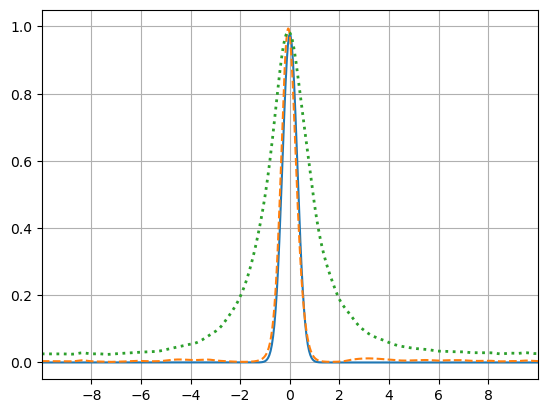

In [35]:
%matplotlib inline
X0 = -13
idx = 9


deconv_slice = data_deconv[idx, :, nearest_elem_index(X0, x_ftian)].copy()
ftian_slice = data_interp[idx, :, nearest_elem_index(X0, x_ftian)].copy()
model_slice = volume[idx, :, nearest_elem_index(X0, x_cutted)].copy()

deconv_slice /= np.max(data_deconv)
ftian_slice /= np.max(data_interp)
model_slice /= np.max(volume)

plt.plot(y_cutted, model_slice, "")

delta_ftian = -0.15
plt.plot(y_ftian+delta_ftian, deconv_slice, "--")
plt.plot(y_ftian+delta_ftian, ftian_slice,  linestyle="dotted", linewidth=2)
plt.ylim(-0.05, 1.05)
plt.xlim(-10, 10)
plt.grid()
# plt.xlabel("$y$, μm")
# plt.ylabel("$I$, a.u.")
plt.xticks(np.arange(-8, 10, step=2))
plt.savefig(f"FTIAN_2/model_pics/24_verh.png", bbox_inches='tight', pad_inches=0, dpi=400)

z = 36.0
nearest elem is -13.004989986648868
nearest elem is -13.004989986648868
nearest elem is -12.950000762939453


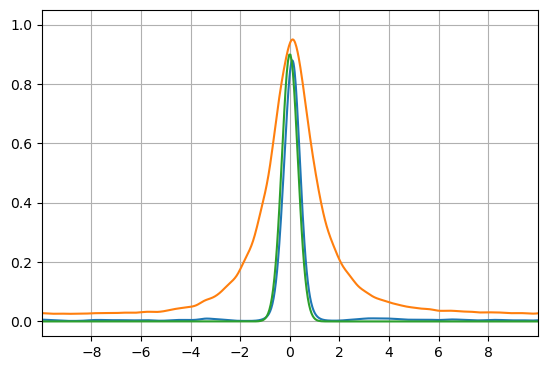

In [34]:
lines_cache = []

def plot_slice_x(x0, idx, x, y, data):

    # предварительная подготовка plot
    from matplotlib.widgets import Slider 

    plt.close()
    %matplotlib inline

    # по x0 находим нужный слой в x
    N_slice = nearest_elem_index(x0, x)
    data = data[:, :, N_slice]
    # data = data / np.max(data)

    # кэширование всех инпутов
    global lines_cache
    lines_cache.append([x0, x, y, data]) 

    # Инициализация графика и его свойства
    fig, ax = plt.subplots()
    plt.subplots_adjust(bottom=0.2)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(-10, 10)
    plt.xticks(np.arange(-8, 10, step=2))
    # plt.xlabel("$y$, μm")
    # plt.ylabel("$I$, a.u.")
    # plt.axvline(0, color='red', linestyle='--')
    # plt.axhline(y = 0.5, color = 'g', alpha=0.8, linewidth=0.5)
    ax.grid()
    

    l_arr = []
    for line in lines_cache:
        l, = ax.plot(line[2], line[3][idx])
        l_arr.append(l)


    # for i, line in enumerate(lines_cache):
    #     l_arr[i].set_ydata(line[3][idx])
    #     l_arr[i].set_xdata(line[2])

    # plt.savefig(f"FTIAN_2/model_pics/24_slice_down.png", bbox_inches='tight', pad_inches=0, dpi=400)
    fig.canvas.draw()
    

X0 = -13
idx = 10
print(f"z = {z_arr[idx]*1e3+2}")

plot_slice_x(X0, idx, x_ftian, y_ftian, data_deconv/np.max(data_deconv))
plot_slice_x(X0, idx, x_ftian, y_ftian, data_interp/np.max(data_interp))
plot_slice_x(X0, idx, x_cutted, y_cutted, volume/np.max(volume))

In [70]:
len(volume)

82

In [117]:
def plot_focal_spot_slider(x, y, z, data):
    
    from matplotlib.widgets import Slider

    %matplotlib tk
    data = np.transpose(data, (2, 1, 0)) / np.max(data)

    # Создаем фигуру и оси
    fig, ax = plt.subplots()
    plt.subplots_adjust(bottom=0.25)
    # ax.grid()
    # Начальное отображение
    c = ax.pcolormesh(z, y, data[0], cmap='CMRmap', vmin=0, vmax=1)
    plt.title(f'x = {x[0]:.1f}')
    plt.colorbar(c)
    plt.ylim(-10, 10)

    plt.xticks(np.arange(z[0], z[-1]+4, step=4))
    plt.yticks(np.arange(-8, 10, step=2))

    # Настраиваем слайдер
    ax_slider = plt.axes([0.17, 0.1, 0.6, 0.03])  # (left, bottom, width, height)
    slider = Slider(ax_slider, 'Index', 0, len(x)-1, valinit=0, valstep=1)

    # Функция обновления графика при изменении слайдера
    def update(val):
        idx = int(slider.val)
        c.set_array(data[idx])
        ax.set_title(f'x = {x[idx]:.1f}')
        fig.canvas.draw()

    slider.on_changed(update)


plot_focal_spot_slider(x_cutted, y_cutted, z_arr*1e3+2,  volume/np.max(volume))
# plot_focal_spot_slider(x_ftian, y_ftian, z_ftian*1e3+2,  data_deconv/np.max(data_deconv))

nearest elem is 13.004989986648866


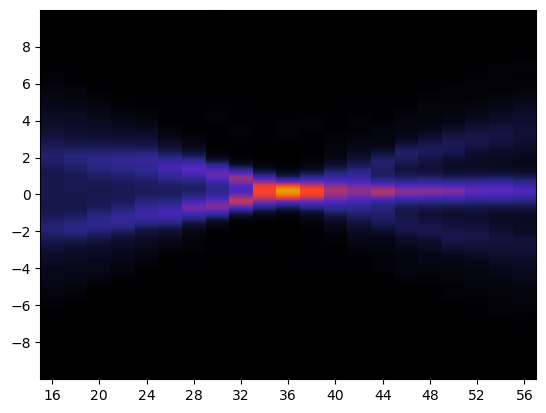

In [38]:
def plot_focal_spot_slice(x0, x, y, z, data):

    %matplotlib inline

    data = np.transpose(data, (2, 1, 0))
    N_slice = nearest_elem_index(x0, x)

    fig, ax = plt.subplots()
    fig.canvas.flush_events()
    # ax.grid()
    # plt.subplots_adjust(bottom=0.25)

    c = ax.pcolormesh(z, y, data[N_slice], shading='auto', cmap='CMRmap', vmin=0, vmax=1)
    # plt.colorbar(c)
    plt.ylim(-10, 10)
    plt.xticks(np.arange(z[0], z[-1]+4, step=4))
    plt.yticks(np.arange(-8, 8+2, step=2))
    # plt.axis("off")
    plt.savefig(f"FTIAN_2/data_output/focal_spot/deconv_verh.png", bbox_inches='tight', pad_inches=0, dpi=400)
    fig.canvas.draw()

x0 = 13
plot_focal_spot_slice(x0, x_ftian, y_ftian, z_arr*1e3+2, data_deconv/np.max(data_deconv))
# plot_focal_spot_slice(x0, x_ftian, y_ftian, z_arr*1e3+2, data_interp/np.max(data_interp))
# plot_focal_spot_slice(x0, x_cutted, y_cutted, z_arr*1e3+2, volume/np.max(volume))